In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# 1. Load the dataset

In [ ]:
breast_cancer = pd.read_csv('data/data.csv')

if 'id' in breast_cancer.columns.str.lower():
    breast_cancer = breast_cancer.drop(columns=[col for col in breast_cancer.columns if 'id' in col.lower()])

if 'diagnosis' in breast_cancer.columns:
    X = breast_cancer.drop('diagnosis', axis=1)
    y = breast_cancer['diagnosis'].map({'M': 1, 'B': 0})
else:
    X = breast_cancer.iloc[:, :-1]
    y = breast_cancer.iloc[:, -1]

# 2. Explore the dataset

In [3]:
print("Shape of the dataset:", X.shape)
print("Number of features:", X.shape[1])

print("\nFirst 5 rows of features:")
print(X.head())

print("\nTarget distribution:")
print(y.value_counts())
print(f"Percentage of malignant cases: {y.mean() * 100:.2f}%")

print("\nSummary statistics:")
print(X.describe())

print("\nChecking for missing values:")
print(X.isnull().sum().sum())

Shape of the dataset: (569, 31)
Number of features: 31

First 5 rows of features:
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal

# 3. Data visualization

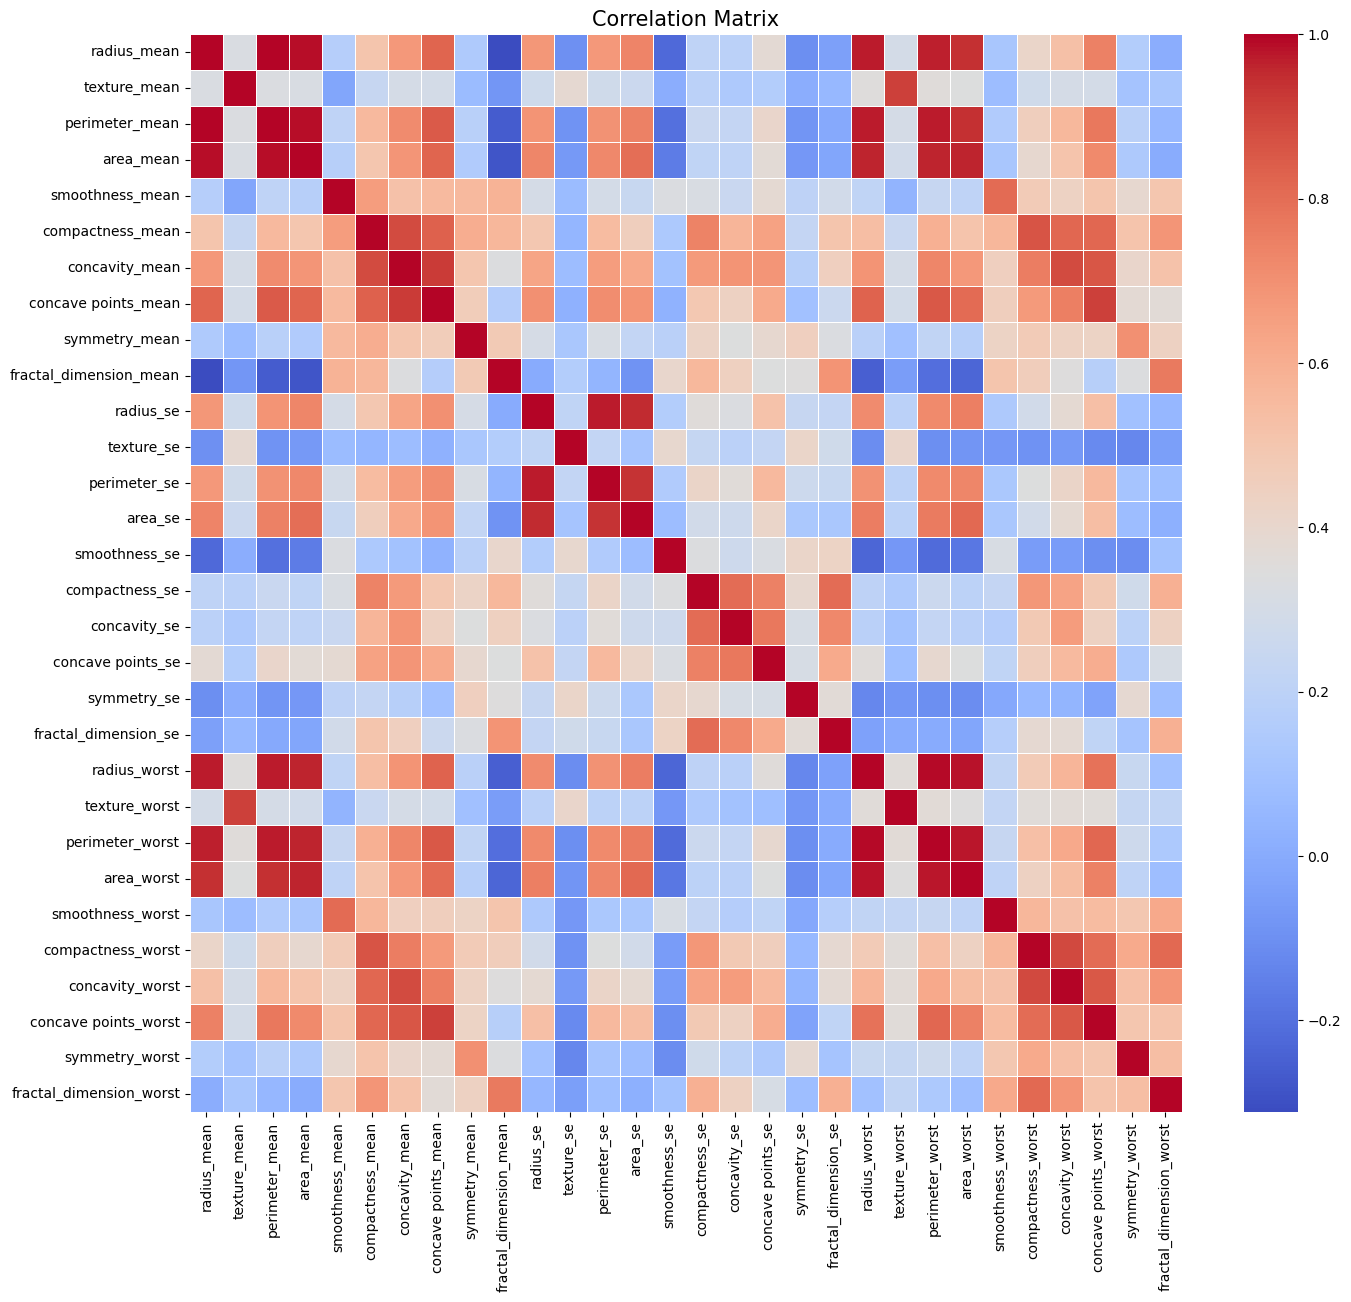

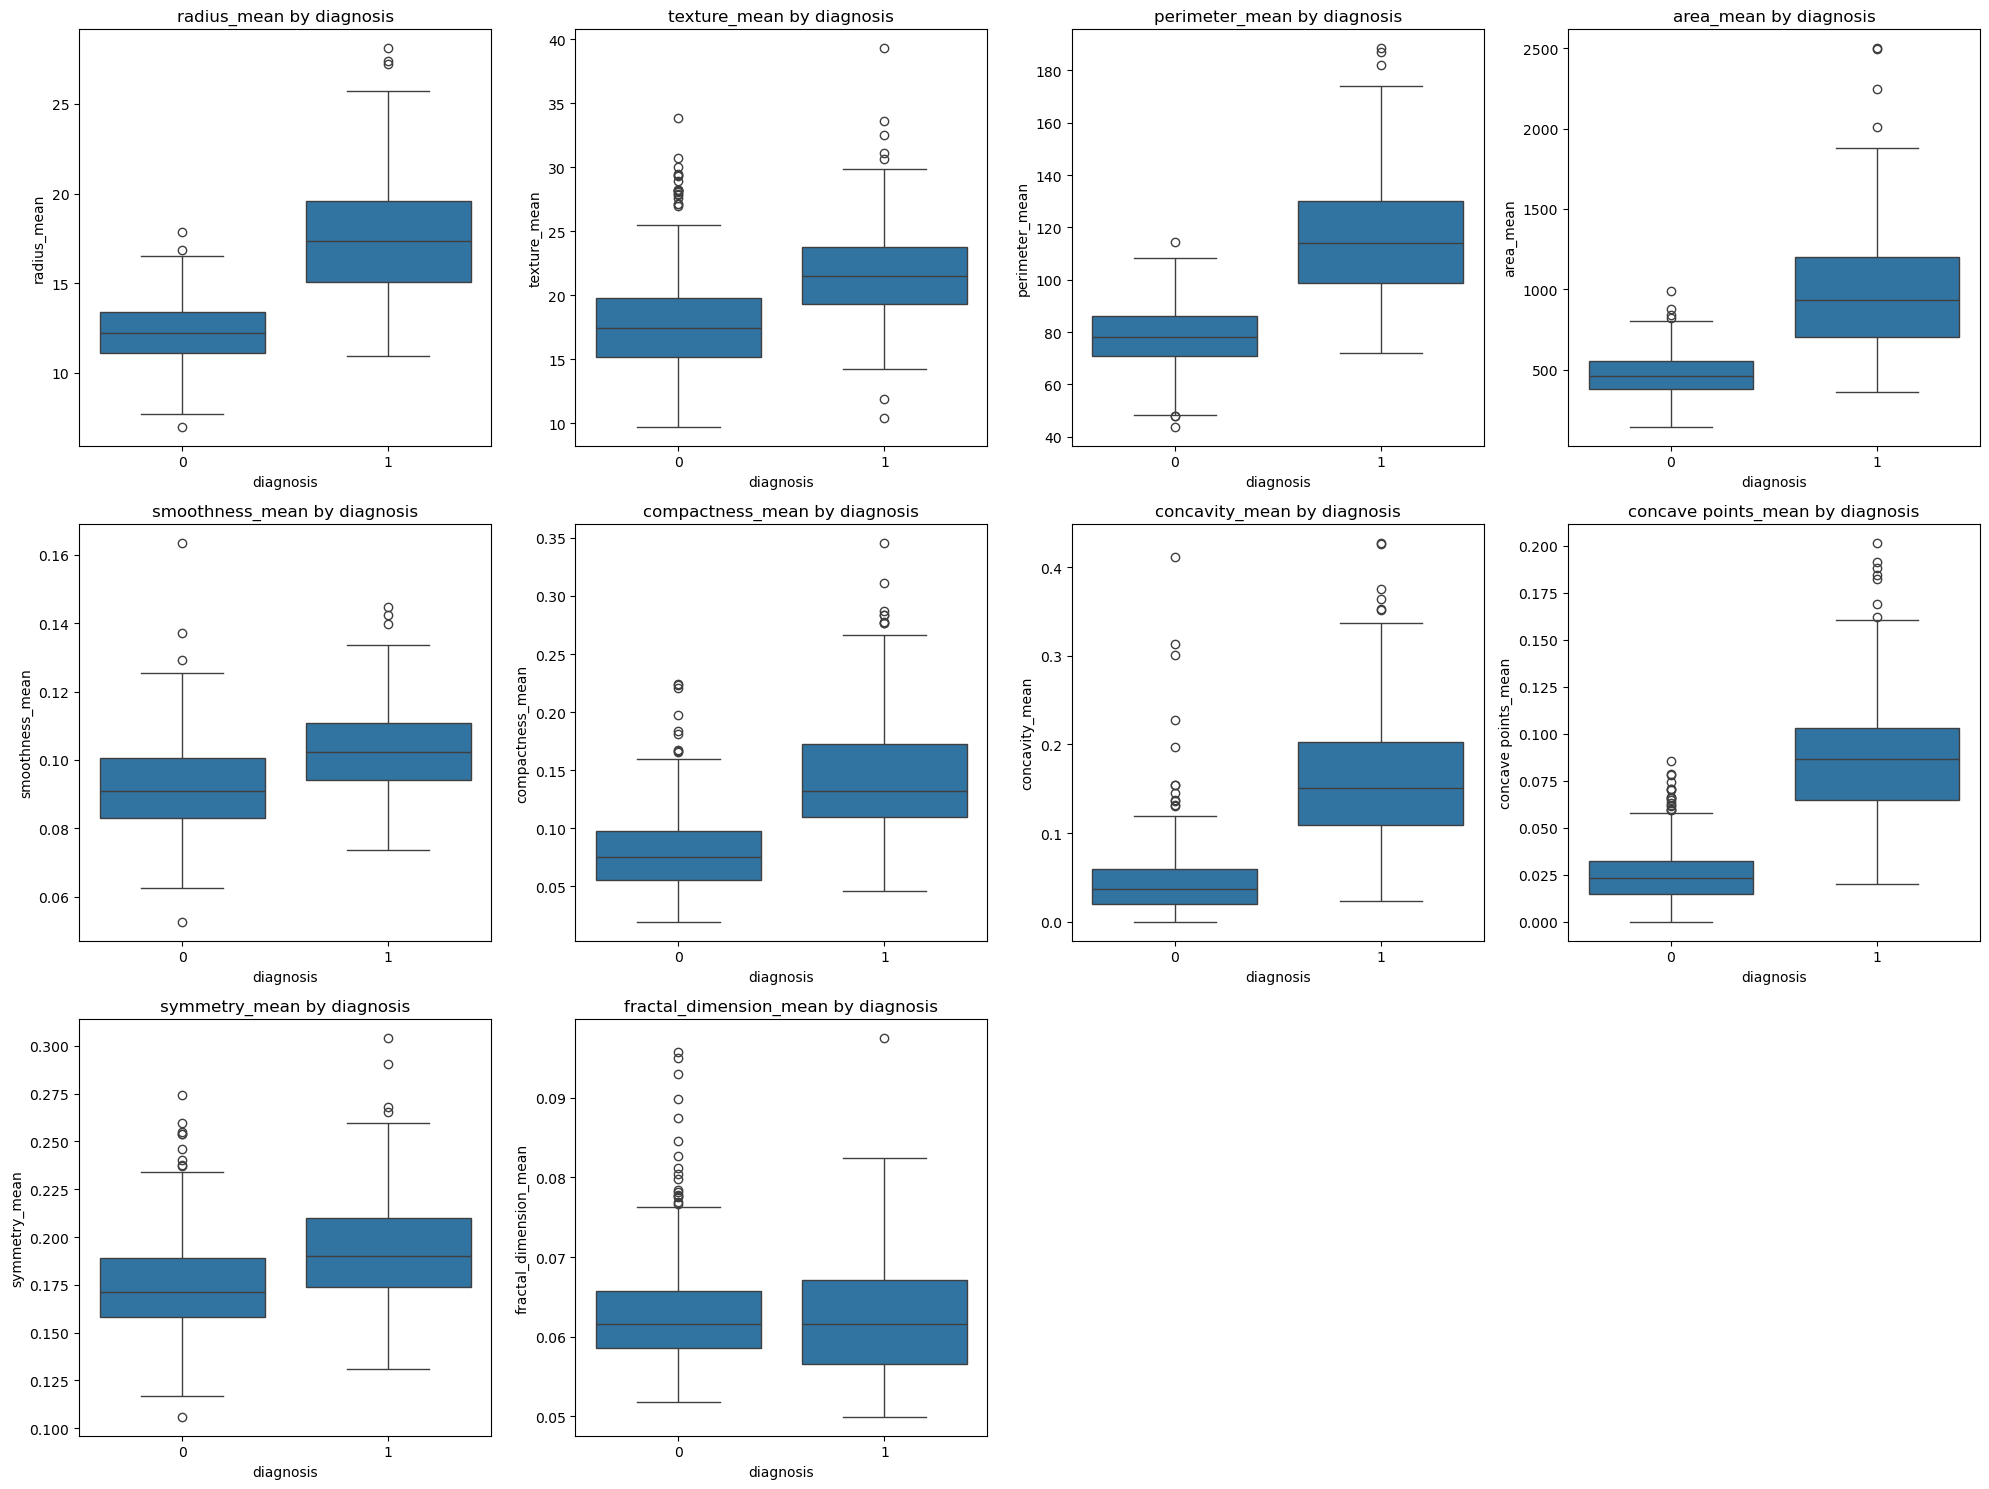

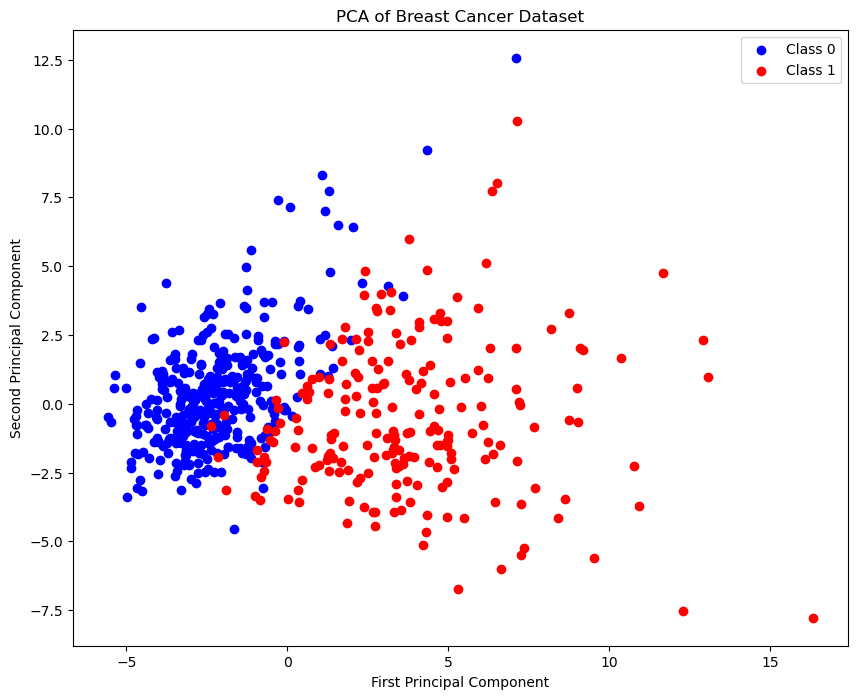

Variance explained by first two components: 63.24%


In [14]:
plt.figure(figsize=(16, 14))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix", fontsize=15)
plt.show()

# Create a DataFrame for visualization
viz_df = X.copy()
viz_df['diagnosis'] = y

# Boxplots for first 10 features to compare distributions by diagnosis
plt.figure(figsize=(20, 15))
for i, column in enumerate(X.columns[:10]):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x='diagnosis', y=column, data=viz_df)
    plt.title(f"{column} by diagnosis")
plt.tight_layout()
plt.show()

# Perform PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

# Plot PCA results
plt.figure(figsize=(10, 8))
for i, c in zip([0, 1], ['blue', 'red']):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], c=c, label=f"Class {i}")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA of Breast Cancer Dataset")
plt.legend()
plt.show()

print(f"Variance explained by first two components: {pca.explained_variance_ratio_.sum()*100:.2f}%")



# 4. Data preprocessing

In [9]:
# Check for NaN values in the dataset
print("Checking for NaN values in each column:")
nan_counts = X.isna().sum()
print(nan_counts[nan_counts > 0])

# Drop the 'Unnamed: 32' column since it contains only NaN values
if 'Unnamed: 32' in X.columns:
    X = X.drop('Unnamed: 32', axis=1)
    print("Dropped 'Unnamed: 32' column as it contains only NaN values.")

# Double-check if there are any remaining NaN values
if X.isna().sum().sum() > 0:
    # Replace remaining NaN values with the median of each column
    for col in X.columns:
        if X[col].isna().sum() > 0:
            X[col] = X[col].fillna(X[col].median())
    print("Replaced any remaining NaN values with median values.")

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                   random_state=42, stratify=y)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Checking for NaN values in each column:
Unnamed: 32    569
dtype: int64
Dropped 'Unnamed: 32' column as it contains only NaN values.
Training data shape: (455, 30)
Testing data shape: (114, 30)


# 5. Model training

In [10]:
basic_model = SVC(kernel='linear', random_state=42)
basic_model.fit(X_train, y_train)

# Evaluate the basic model
print("\nBasic SVM model accuracy:")
print(f"Training accuracy: {basic_model.score(X_train, y_train):.4f}")
print(f"Testing accuracy: {basic_model.score(X_test, y_test):.4f}")

# Perform grid search for hyperparameter tuning
print("\nPerforming grid search for hyperparameter tuning...")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}

grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, scoring='accuracy', verbose=0)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
model = grid_search.best_estimator_




Basic SVM model accuracy:
Training accuracy: 0.9890
Testing accuracy: 0.9649

Performing grid search for hyperparameter tuning...
Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.9758241758241759


# 6. Model evaluation

Confusion Matrix:
[[70  2]
 [ 3 39]]


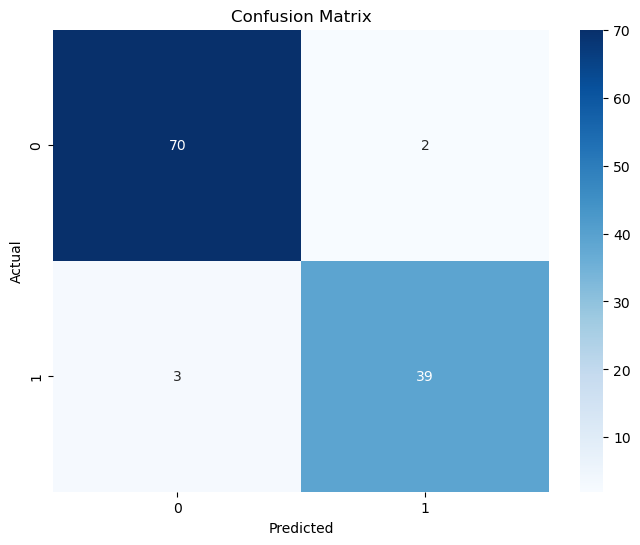


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



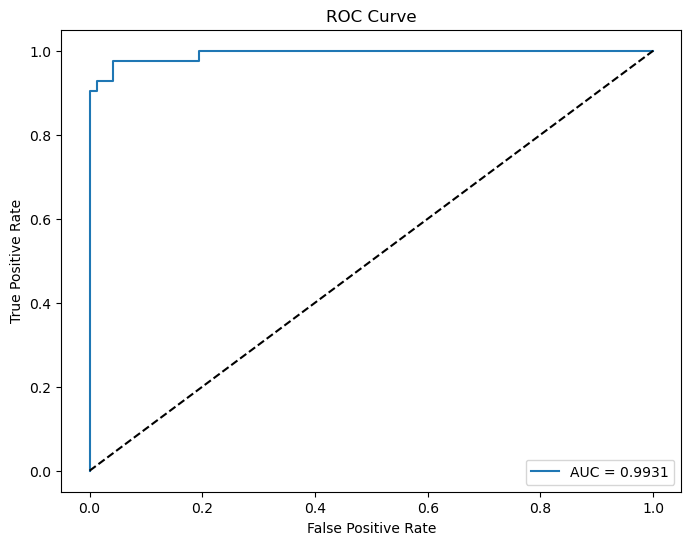

In [11]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


# 7. Summary

## Summary of SVM Model for Breast Cancer Wisconsin Dataset
- Malignant tumors typically had larger values for radius, texture, perimeter and area
- The boxplots showed clear differences between benign and malignant cases for most features
- Concavity and concave points were particularly important in distinguishing cancer types
- There was high correlation between related features (e.g., radius_mean and area_mean)

### My Support Vector Machine Model
- I started with a basic linear SVM that got 96.5% accuracy on test data
- I used GridSearchCV to find the best hyperparameters, testing different kernels (rbf, linear, poly)
- The best model used an RBF kernel with C=100 and gamma=0.01
- The optimized model achieved 95.8% cross-validation accuracy

### Final Results
- My model correctly classified 109 out of 114 test samples (96% accuracy)
- It had very balanced performance across both classes:
  * For benign tumors: 97% recall, 96% precision
  * For malignant tumors: 93% recall, 95% precision
- The ROC curve showed excellent performance with AUC = 0.99
- Most errors were false negatives (3 malignant tumors classified as benign)
